In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np
from numpy import pi,exp,sin,cos,sqrt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
plt.style.use('default')
from scipy_ivp import solve_with_event


In [2]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


In [3]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue = 10 # for cue distribution
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [5]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,x_tilde,k_prior,k_cue,t_lastFire,T_theta):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # t_Lastfire is the last time when x_fires
    # Calculate last firing phase
    t_lastFire = np.array(t_lastFire)
    x_fire = 2*pi*t_lastFire/T_theta
    fired = np.isfinite(x_fire)
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x_fire[fired] # dxi[j] = x[i] - x[j] for j in where(fired)
        H[i] = np.dot( W[i,fired], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    tau = T_theta*8 # 1000 ms
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx/tau

In [6]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
xNoise = np.random.vonmises(0,k_cue,N)
x_tilde = xTarget + xNoise
x0 = np.random.vonmises(0,k_prior,N)

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta*80
t_eval = np.arange(0,tf,1)
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue': k_cue,
    'sigma2_W': sigma2_W,
    'x_tilde': x_tilde,
    'T_theta': T_theta
}
odeWaitingEvent = lambda t,y,t_events_last: mainode(t,y,t_lastFire=t_events_last,**kwargs)
sol = solve_with_event(odeWaitingEvent,(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


(<a list of 9 Line2D gridline objects>,
 <a list of 9 Text major ticklabel objects>)

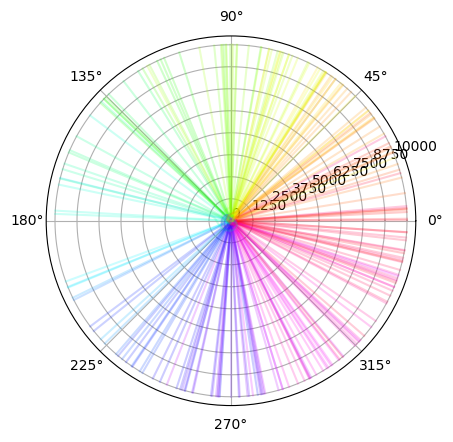

In [7]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
# ax.plot(2*pi*t/T_theta,t,color='gray',alpha=0.9)
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.set_rgrids(range(0,tf+1,T_theta*10))

In [8]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi

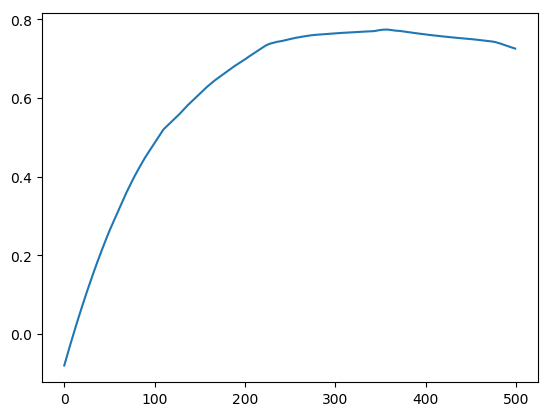

In [9]:
plt.plot(t[t<500],errors[0,t<500])

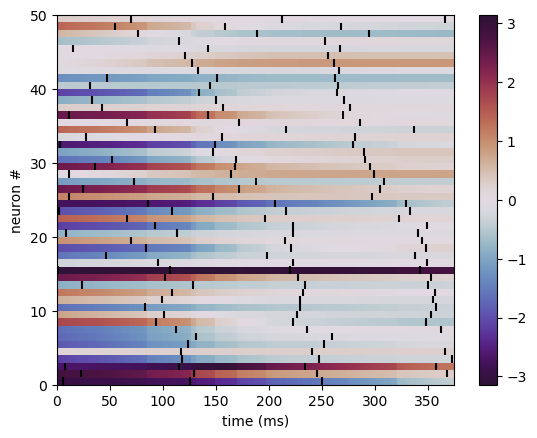

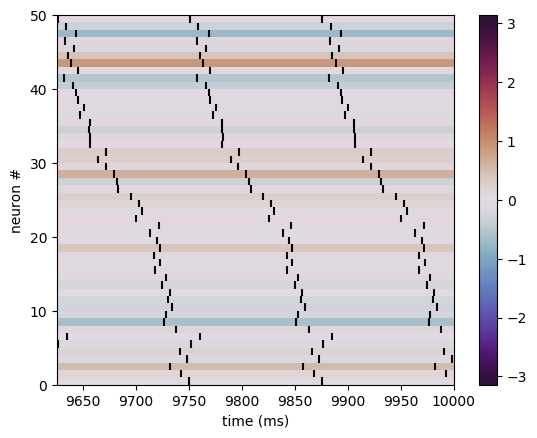

In [14]:
# define raster
def raster(x_fire,inds,t,errors):
        # print(errors.shape)
        fig,ax = plt.subplots()
        background = ax.imshow(errors[inds,:],cmap='twilight_shifted',aspect='auto',vmin=-pi,vmax=pi)
        background.set_extent((t[0],t[-1],0,len(inds)))
        for iy,ii in enumerate(inds):
                for te in x_fire[ii]:
                        if te>t[-1]:
                                break
                        if te>t[0]:
                                ax.vlines(te,iy,iy+1,color='black')
        ax.set_xlim((t[0],t[-1]))
        ax.set_ylim((0,len(inds)))
        ax.set_xlabel('time (ms)')
        ax.set_ylabel('neuron #')
        fig.colorbar(background)
ind = np.linspace(0,N-1,50).astype(int)
sortedind = np.argsort(np.mod(xTarget,2*pi))[::-1][ind]
it1 = np.where(t<T_theta*3)
raster(t_fire,sortedind,t[it1],errors[:,it1[0]])
it2 = np.where(t>T_theta*77)
raster(t_fire,sortedind,t[it2],errors[:,it2[0]])